In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.5/898.5 kB 33.1 MB/s eta 0:00:00



image 1/1 /content/photo_2024-12-05_11-29-53.jpg: 480x640 2 car-tires, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


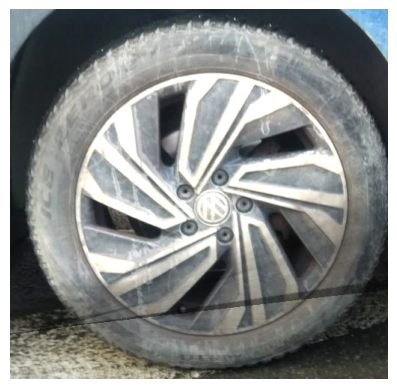

In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from ultralytics import YOLO

def compute_homography(img_opt_gray, img_thr, method='SIFT', ratio=0.75, min_matches=5):
    if method == 'SIFT':
        detector = cv2.SIFT_create()
    else:
        detector = cv2.ORB_create(5000)
    kp1, d1 = detector.detectAndCompute(img_opt_gray, None)
    kp2, d2 = detector.detectAndCompute(img_thr, None)
    if d1 is None or d2 is None or len(d1) == 0 or len(d2) == 0:
        return None
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    try:
        matches = flann.knnMatch(d1, d2, k=2)
    except:
        return None
    good = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good.append(m)
    if len(good) < min_matches:
        return None
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    H, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)
    return H

def align_and_transform_advanced(image1, image2, ratio=0.75, min_matches=5):
    img_opt = image1
    img_thr_color = image2
    img_thr = cv2.cvtColor(img_thr_color, cv2.COLOR_BGR2GRAY) if len(img_thr_color.shape) == 3 else img_thr_color
    img_opt_gray = cv2.cvtColor(img_opt, cv2.COLOR_BGR2GRAY)

    H = compute_homography(img_opt_gray, img_thr, 'SIFT', ratio, min_matches)
    if H is None:
        H = compute_homography(img_opt_gray, img_thr, 'ORB', ratio, min_matches)

    if H is None:
        print("Не удалось вычислить гомографию ни с SIFT, ни с ORB. Возвращаем исходное оптическое изображение.")
        return img_opt

    H_inv = np.linalg.inv(H)
    h_opt, w_opt = img_opt.shape[:2]
    img_thr_trans = cv2.warpPerspective(img_thr, H_inv, (w_opt, h_opt))

    img_thr_norm = img_thr_trans.astype(np.float32) / 255.0
    brightness_factor = 0.5 + img_thr_norm

    img_opt_float = img_opt.astype(np.float32)

    if len(img_opt.shape) == 3:
        brightness_factor = np.expand_dims(brightness_factor, axis=-1)

    enhanced = img_opt_float * brightness_factor

    enhanced = np.clip(enhanced, 0, 255).astype(np.uint8)

    return enhanced

def detect_and_crop(image_path, model_path, class_name):
    model = YOLO(model_path)
    results = model(image_path)
    boxes = results[0].boxes
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError("Изображение не загружено.")
    target_boxes = []
    for box in boxes:
        cls = int(box.cls.cpu().numpy()[0])
        if results[0].names[cls] == class_name:
            x1, y1, x2, y2 = box.xyxy.cpu().numpy()[0].astype(int)
            target_boxes.append((x1, y1, x2, y2))
    if len(target_boxes) == 0:
        raise ValueError(f"Не найдены объекты класса {class_name} на изображении.")
    x1, y1, x2, y2 = target_boxes[0]
    cropped = img[y1:y2, x1:x2]
    return cropped

image_opt_path = "/content/photo_2024-12-05_11-29-53.jpg"
image_thr_path = "/content/img_20241205_140031.png"
model_path = "/content/best.pt"

cropped_opt = detect_and_crop(image_opt_path, model_path, "car-tire")
image_thr = cv2.imread(image_thr_path)
overlay_result = align_and_transform_advanced(cropped_opt, image_thr, ratio=0.75, min_matches=5)


output_path = "/сontent/result_image.png"
cv2.imwrite(output_path, overlay_result)

plt.imshow(cv2.cvtColor(overlay_result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [29]:
!pip install roboflow supervision opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [33]:
from roboflow import Roboflow
import supervision as sv
import cv2

rf = Roboflow(api_key="cTkGDuiXcBRIjEIKbB9q")
project = rf.workspace().project("wheeltester")
model = project.version(2).model

result = model.predict("/content/photo_2024-12-05_11-29-53.jpg", confidence=40, overlap=30).json()


labels = [item["class"] for item in result["predictions"]]

loading Roboflow workspace...
loading Roboflow project...


In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="cTkGDuiXcBRIjEIKbB9q")
project = rf.workspace("testwheel").project("wheeltester")
version = project.version(2)
dataset = version.download("yolov8")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Wheeltester-2 in yolov8:: 100%|██████████| 4490/4490 [00:00<00:00, 4636.72it/s]


In [2]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.5/898.5 kB 29.9 MB/s eta 0:00:00


In [4]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

# Запускаем обучение
model.train(
    data='/content/Wheeltester-2/data.yaml',
    epochs=25,
    imgsz=640,
    batch=16,
    workers=4,
    project='/content/Wheeltester-2/result',
    name='result'
)


Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/Wheeltester-2/data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=4, project=/content/Wheeltester-2/result, name=result, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=

100%|██████████| 755k/755k [00:00<00:00, 24.9MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 111MB/s]


AMP: checks passed ✅


train: Scanning /content/Wheeltester-2/train/labels... 1672 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1672/1672 [00:00<00:00, 1908.99it/s]

train: New cache created: /content/Wheeltester-2/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/Wheeltester-2/valid/labels... 464 images, 0 backgrounds, 0 corrupt: 100%|██████████| 464/464 [00:00<00:00, 1248.79it/s]

val: New cache created: /content/Wheeltester-2/valid/labels.cache


Plotting labels to /content/Wheeltester-2/result/result/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/Wheeltester-2/result/result
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      2.22G     0.8278      1.666      1.247         57        640: 100%|██████████| 105/105 [00:36<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.83it/s]

                   all        464        479    0.00596      0.944      0.105     0.0372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      2.19G     0.7747      1.092      1.176         53        640: 100%|██████████| 105/105 [00:33<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.77it/s]

                   all        464        479     0.0078      0.921     0.0335     0.0103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      2.28G     0.7611      1.004      1.155         37        640: 100%|██████████| 105/105 [00:32<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.33it/s]

                   all        464        479    0.00782      0.764    0.00909    0.00426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      2.19G     0.7364     0.9117      1.141         31        640: 100%|██████████| 105/105 [00:33<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.32it/s]

                   all        464        479     0.0361      0.927      0.142     0.0639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      2.19G     0.7319     0.9088      1.141         42        640: 100%|██████████| 105/105 [00:32<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.21it/s]

                   all        464        479     0.0348      0.595     0.0328      0.015



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25       2.2G     0.6961     0.8253      1.117         49        640: 100%|██████████| 105/105 [00:32<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.17it/s]

                   all        464        479      0.108      0.806      0.284      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      2.18G     0.6652     0.7877      1.103         41        640: 100%|██████████| 105/105 [00:31<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]

                   all        464        479     0.0975      0.388      0.109     0.0353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      2.29G     0.6577     0.7602      1.094         47        640: 100%|██████████| 105/105 [00:32<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.05it/s]

                   all        464        479       0.32       0.42      0.283      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      2.27G     0.6566     0.7469      1.093         41        640: 100%|██████████| 105/105 [00:33<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.21it/s]

                   all        464        479     0.0443      0.138      0.029     0.0148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      2.42G     0.6266     0.7035      1.071         36        640: 100%|██████████| 105/105 [00:33<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.12it/s]

                   all        464        479      0.103      0.217     0.0685     0.0466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      2.18G     0.6101     0.7076      1.068         86        640: 100%|██████████| 105/105 [00:32<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.52it/s]

                   all        464        479     0.0759      0.123     0.0434     0.0231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      2.25G     0.6027     0.6722      1.056         48        640: 100%|██████████| 105/105 [00:31<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]

                   all        464        479      0.308     0.0251      0.159      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      2.31G      0.576     0.6577       1.05         40        640: 100%|██████████| 105/105 [00:32<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]

                   all        464        479     0.0865     0.0898     0.0532     0.0353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      2.18G     0.5852     0.6532      1.045         45        640: 100%|██████████| 105/105 [00:32<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.13it/s]

                   all        464        479      0.684      0.113       0.39      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      2.24G     0.5704     0.6468      1.044         33        640: 100%|██████████| 105/105 [00:33<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.22it/s]

                   all        464        479      0.412     0.0146      0.209      0.179


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      2.18G     0.5851     0.5974      1.056         24        640: 100%|██████████| 105/105 [00:33<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.83it/s]

                   all        464        479      0.188     0.0752      0.104     0.0633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      2.15G     0.5724     0.5825      1.048         24        640: 100%|██████████| 105/105 [00:29<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]

                   all        464        479        0.4     0.0125      0.206      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      2.22G     0.5701     0.5503       1.04         20        640: 100%|██████████| 105/105 [00:29<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]

                   all        464        479        0.3     0.0125      0.157     0.0831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      2.22G     0.5344     0.5407      1.027         23        640: 100%|██████████| 105/105 [00:29<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.31it/s]

                   all        464        479        0.4    0.00418      0.201      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      2.16G     0.5411     0.5113       1.02         27        640: 100%|██████████| 105/105 [00:31<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.14it/s]

                   all        464        479       0.25    0.00418      0.126      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      2.21G     0.5146     0.4963      1.011         19        640: 100%|██████████| 105/105 [00:31<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.16it/s]

                   all        464        479       0.25    0.00418      0.126      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      2.22G     0.4918     0.4739     0.9994         30        640: 100%|██████████| 105/105 [00:32<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.32it/s]

                   all        464        479       0.25    0.00418      0.126      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      2.21G      0.488     0.4664     0.9957         27        640: 100%|██████████| 105/105 [00:32<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.25it/s]

                   all        464        479       0.25    0.00418      0.126      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      2.21G     0.4689     0.4469     0.9861         21        640: 100%|██████████| 105/105 [00:31<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.15it/s]

                   all        464        479       0.25    0.00418      0.126      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      2.21G     0.4557     0.4334     0.9806         44        640: 100%|██████████| 105/105 [00:31<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.20it/s]

                   all        464        479       0.25    0.00418      0.126      0.113



25 epochs completed in 0.262 hours.
Optimizer stripped from /content/Wheeltester-2/result/result/weights/last.pt, 6.2MB
Optimizer stripped from /content/Wheeltester-2/result/result/weights/best.pt, 6.2MB

Validating /content/Wheeltester-2/result/result/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


                   all        464        479      0.684      0.113       0.39      0.294
                  Tire        464        479      0.684      0.113       0.39      0.294
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to /content/Wheeltester-2/result/result


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b4f4d445390>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 